# Diffusion and Dispersion in Solute Transport

Breakthrough curve spreading arises from three independent processes:

| Component                 | Symbol          | Physical cause                 | Velocity scaling                          |
| ------------------------- | --------------- | ------------------------------ | ----------------------------------------- |
| **Aquifer heterogeneity** | $\sigma_{apv}$  | Different streamline lengths   | $\propto \tau$                            |
| **Molecular diffusion**   | $\sigma_{diff}$ | Brownian motion                | $\propto \sqrt{\tau}$, independent of $v$ |
| **Mechanical dispersion** | $\sigma_{disp}$ | Pore-scale velocity variations | $\propto \sqrt{\tau}$, scales with $v$    |

**Key insight**: $\sigma_{apv}$ and $\sigma_{disp}$ are physically similar - both arise from velocity variations at different scales. When flow is constant $\sigma_{apv}$, $\sigma_{disp}$  and $\sigma_{diff}$ may be combined and passed as `std` to `advection.gamma_infiltration_to_extraction`.


## Modeling Approaches

| Method                   | Function                                     | Speed | Use when                      |
| ------------------------ | -------------------------------------------- | ----- | ----------------------------- |
| **APVD only**            | `advection.gamma_infiltration_to_extraction` | Fast  | Dispersion negligible         |
| **APVD + increased std** | Same, with adjusted `std`                    | Fast  | Approximate dispersion. Flow relatively constant. |
| **Full solution**        | `diffusion2.infiltration_to_extraction`      | Slow  | Variable flow, high precision |


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gwtransport import advection, diffusion2
from gwtransport import gamma as gamma_utils

np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

## 1. System Parameters


In [2]:
# Aquifer geometry
streamline_length = 100.0  # [m]
mean_apv = 10000.0  # [m³] Mean aquifer pore volume
std_apv = 800.0  # [m³] Std from aquifer heterogeneity

# Flow
mean_flow = 120.0  # [m³/day]

# Transport
retardation = 2.0  # [-] Retardation factor
diffusivity_molecular = 1e-4  # [m²/day] Molecular diffusion (~1e-9 m²/s)
dispersivity = 1.0  # [m] Longitudinal dispersivity

# Derived quantities
tau_water = mean_apv / mean_flow
tau_solute = retardation * tau_water
velocity = streamline_length / tau_water
diffusivity = diffusivity_molecular + dispersivity * velocity  # Total dispersion coefficient

print(f"Water residence time:  {tau_water:.1f} days")
print(f"Solute residence time: {tau_solute:.1f} days")
print(f"Water velocity:        {velocity:.2f} m/day")
print(f"diffusivity = diffusivity_molecular + dispersivity * v: {diffusivity:.3f} m²/day")

Water residence time:  83.3 days
Solute residence time: 166.7 days
Water velocity:        1.20 m/day
diffusivity = diffusivity_molecular + dispersivity * v: 1.200 m²/day


## 2. Variance Components

Spatial spreading from diffusion/dispersion: $\sigma_x = \sqrt{2 D_L \tau_{solute}}$

Convert to temporal spreading: $\sigma_t = \sigma_x / v_{water}$

Convert to APVD units: $\Delta\sigma_{apv} = \sigma_t \cdot Q$


In [3]:
# Spatial spreading from diffusion + dispersion
sigma_x = np.sqrt(2 * diffusivity * tau_solute)  # [m]

# Convert to temporal spreading (using water velocity)
sigma_t_diffdisp = sigma_x / velocity  # [days]

# Convert to APVD units
delta_sigma_apv = sigma_t_diffdisp * mean_flow  # [m³]

# Individual components (for understanding)
sigma_t_diff = np.sqrt(2 * diffusivity_molecular * tau_solute) / velocity
sigma_t_disp = np.sqrt(2 * dispersivity * velocity * tau_solute) / velocity

print("Temporal spreading contributions:")
print(f"  From molecular diffusion: {sigma_t_diff:.2f} days")
print(f"  From mechanical dispersion: {sigma_t_disp:.2f} days")
print(f"  Combined (diff + disp): {sigma_t_diffdisp:.2f} days")
print(f"\nEquivalent APVD spreading: delta_std_apv = {delta_sigma_apv:.0f} m³")

Temporal spreading contributions:
  From molecular diffusion: 0.15 days
  From mechanical dispersion: 16.67 days
  Combined (diff + disp): 16.67 days

Equivalent APVD spreading: delta_std_apv = 2000 m³


## 3. Equivalent APVD Standard Deviation

Combine original APVD heterogeneity with diffusion/dispersion spreading:

$$\sigma_{apv,combined} = \sqrt{\sigma_{apv}^2 + \Delta\sigma_{apv}^2}$$


In [4]:
# Combined APVD std
sigma_apv_combined = np.sqrt(std_apv**2 + delta_sigma_apv**2)

# Variance fractions
frac_apv = std_apv**2 / sigma_apv_combined**2 * 100
frac_diffdisp = delta_sigma_apv**2 / sigma_apv_combined**2 * 100

print(f"Original std_apv:    {std_apv:7.0f} m³  ({frac_apv:.0f}% of variance)")
print(f"Δstd_apv (diff+disp):{delta_sigma_apv:7.0f} m³  ({frac_diffdisp:.0f}% of variance)")
print(f"Combined std_apv:    {sigma_apv_combined:7.0f} m³")

print("\n" + "=" * 50)
if frac_diffdisp < 5:
    print("RECOMMENDATION: Ignore diffusion/dispersion")
elif frac_diffdisp < 25:
    print("RECOMMENDATION: Use APVD with increased std")
else:
    print("RECOMMENDATION: Use diffusion2 for accuracy")
print("=" * 50)

Original std_apv:        800 m³  (14% of variance)
Δstd_apv (diff+disp):   2000 m³  (86% of variance)
Combined std_apv:       2154 m³

RECOMMENDATION: Use diffusion2 for accuracy


## 4. Numerical Validation


In [5]:
n_days = 350
_tedges = pd.date_range("2019-12-31", periods=n_days + 1, freq="D")

_flow = np.full(n_days, mean_flow)
_cin = np.zeros(n_days)
_cin[50] = 100.0

cin_itedges = np.flatnonzero(np.diff(_cin, prepend=1.0, append=1.0))
flow_itedges = np.flatnonzero(np.diff(_flow, prepend=1.0, append=1.0))
itedges = np.unique(np.concatenate([cin_itedges, flow_itedges]))
tedges = _tedges[itedges]

cin = _cin[itedges[:-1]]
flow = _flow[itedges[:-1]]

cout_tedges = _tedges.copy()

nbins = 5000
streamline_lengths = np.full(nbins, streamline_length)

In [6]:
# 1. APVD only (no diffusion/dispersion)
cout_apvd = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=std_apv,
    n_bins=nbins,
    retardation_factor=retardation,
)

# 2. Full solution: diffusion2 with APVD + diffusion/dispersion
gbins = gamma_utils.bins(mean=mean_apv, std=std_apv, n_bins=nbins)
cout_full = diffusion2.infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=gbins["expected_values"],
    streamline_length=streamline_lengths,
    diffusivity=diffusivity,
    retardation_factor=retardation,
)

# 3. APVD with combined std (approximation)
cout_apvd_combined = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=sigma_apv_combined,
    n_bins=nbins,
    retardation_factor=retardation,
)

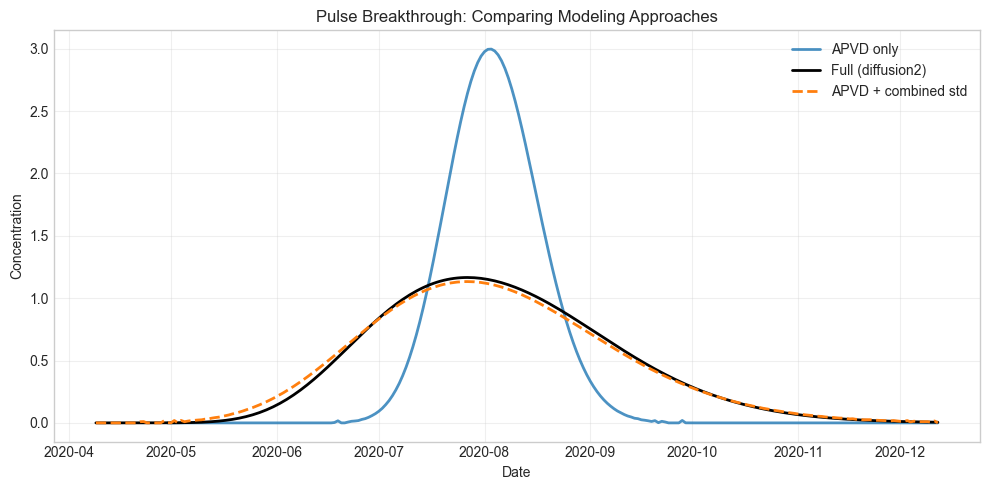

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot around breakthrough
plot_start, plot_end = 100, 349
# print(np.nansum(cout_apvd[plot_start:plot_end-1]), cout_full[plot_start:plot_end-1].sum())
t_plot = cout_tedges[plot_start:plot_end]

ax.plot(t_plot[:-1], cout_apvd[plot_start : plot_end - 1], label="APVD only", linewidth=2, alpha=0.8)
ax.plot(
    t_plot[:-1],
    cout_full[plot_start : plot_end - 1],
    label="Full (diffusion2)",
    linewidth=2,
    linestyle="-",
    color="black",
)
ax.plot(
    t_plot[:-1], cout_apvd_combined[plot_start : plot_end - 1], label="APVD + combined std", linewidth=2, linestyle="--"
)

ax.set_xlabel("Date")
ax.set_ylabel("Concentration")
ax.set_title("Pulse Breakthrough: Comparing Modeling Approaches")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# The minor remaining difference might be due to that the advection module assumes a gamma distribution and the diffusion2 a normal distribution.

## Summary

**Formula for equivalent APVD spreading:**

$$\Delta\sigma_{apv} = \bar{V} \cdot \frac{\sqrt{2 D_L \tau_{solute}}}{L}$$

where $D_L = D_m + \alpha_L v$ and $\tau_{solute} = R \cdot \bar{V} / Q$

**When to include diffusion/dispersion:**

- $\Delta\sigma_{apv}^2 / \sigma_{apv}^2 < 0.05$: Ignore

- Ratio 0.05-0.25: Use combined std approximation

- Ratio > 0.25: Use `diffusion2.infiltration_to_extraction`
